# Q5 Assumed Density Filtering
### Q5.1 Pre-processing and variables

In [16]:
# Q5 Assumed density filtering
# import preprocessing function and Gibbs sampler function
from Preprocessing_serieA_function import preprocess_serieA_no_draws
from Gibbs_sampler_function import gibbs_sampling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# load data
data = pd.read_csv('SerieA_dataset.csv')

# preprocess data
data_preprocessed = preprocess_serieA_no_draws(data)
print(data_preprocessed.head())

# Create team dictionary test 1
unique_teams_1 = data_preprocessed['team1'].unique().tolist()
mean=[25 for i in range(len(unique_teams_1))]
variance=[64 for i in range(len(unique_teams_1))]

teams_dictionary = {i:[25,64] for i in unique_teams_1}

# Create team dictionary test 2 for shuffled data
shuffled_teams_dictionary = {i:[25,64] for i in unique_teams_1}

# shuffle data
shuffled_data = data_preprocessed.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)
print(shuffled_data.head())

# print(teams_dictionary)

game1 = data_preprocessed.iloc[0, :]
# print(game1[0])
# print(f'\nFirst game:\n {game1}')

      team1     team2  y
0    Chievo  Juventus -1
1     Lazio    Napoli -1
2    Torino      Roma -1
3  Sassuolo     Inter  1
5    Empoli  Cagliari  1
        team1      team2  y
0  Fiorentina   Atalanta  1
1  Fiorentina  Frosinone -1
2       Lazio   Atalanta -1
3    Sassuolo   Cagliari  1
4   Sampdoria    Udinese  1


# Q.6
### Q6.1 prediction function

In [17]:
# Prediction function (deterministic)
# if skills are equal, team 1 wins, might need to change this
def prediction(team1_mean, team2_mean):
    if team1_mean > team2_mean:
        return 1
    elif team1_mean < team2_mean:
        return -1
    elif team1_mean == team2_mean:
        return 1
    else:
        print('Error in prediction function')


### Q5.2 Assumed Density Filtering (ADF) function

In [18]:
# Assumed density filtering (ADF)
def ADF(teams_dictionary, dataframe):
    # print(dataframe.head())
    # print(teams_dictionary)

    # Assumed density filtering (ADF)
    n_iter = 3000
    t_var = 6
    burn_in = 500

    # One step ahead prediction
    predictions = []
    # Loop over all games

    for index, game1 in dataframe.iterrows():
        
        # Load means and variances from dictionary
      
        mean_team1 = float(teams_dictionary[game1[0]][0])
        mean_team2 = float(teams_dictionary[game1[1]][0])

        variance_team1 = float(teams_dictionary[game1[0]][1])
        variance_team2 = float(teams_dictionary[game1[1]][1])

        # One-Step-Ahead prediction
        y_pred = prediction(mean_team1, mean_team2)
        predictions.append(y_pred)
        
        # create mean column and covariance matrix
        s1_s2_mean_col = np.array([[mean_team1, mean_team2]]).reshape(-1,1)
        s_cov_matrix = np.array([[variance_team1, 0], [0, variance_team2]])

        y = game1['y']

        s1_samples, s2_samples = gibbs_sampling(n_iter, s1_s2_mean_col, s_cov_matrix, t_var, y)

        # results
        s1_samples = s1_samples[burn_in:]
        s2_samples = s2_samples[burn_in:]

        s1_mean = np.mean(s1_samples)
        s2_mean = np.mean(s2_samples)
        s1_var = np.var(s1_samples)
        s2_var = np.var(s2_samples)

        # Update team dictionary means
        teams_dictionary[game1[0]][0] = s1_mean
        teams_dictionary[game1[1]][0] = s2_mean

        # update team dictionary variances
        teams_dictionary[game1[0]][1] = s1_var
        teams_dictionary[game1[1]][1] = s2_var

    return teams_dictionary, predictions

## Q5 & Q6: Run functions

In [19]:
# Run ADF on data
dic1, predictions1= ADF(teams_dictionary, data_preprocessed)

# Run ADP on shuffled data
dic_shuffled, predictions_shuffled = ADF(shuffled_teams_dictionary, shuffled_data)

Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibbs sampling...
Running Gibb

# Results:
### Team ranking changes after shuffle
#### prediction rate of one-step-head = 0.64, better than random guessing(0.5)

In [22]:
# Create dataframe of means and variances an sort by means
teams_df = pd.DataFrame(dic1, index=['mean', 'variance']).T
teams_df = teams_df.sort_values(by=['mean'], ascending=False)
print('Teams after the season, no shuffle:')
print(teams_df)

# Calculate prediction rate
from sklearn.metrics import accuracy_score
y_true = data_preprocessed['y'].tolist()
prediction_rate = accuracy_score(y_true, predictions1)
print(f'\nPrediction rate of One-Step-Ahead prediction: {prediction_rate}')

# prediction rate of last 60 games
y_true_last_60 = y_true[-60:]
predictions_last_60 = predictions1[-60:]
prediction_rate_last_60 = accuracy_score(y_true_last_60, predictions_last_60)
print(f'\nPrediction rate of One-Step-Ahead prediction for last 60 games: {prediction_rate_last_60}')


# create dataframe of shuffled means and variances
teams_df_shuffled = pd.DataFrame(dic_shuffled, index=['mean', 'variance']).T
teams_df_shuffled = teams_df_shuffled.sort_values(by=['mean'], ascending=False)
print('\nTeams after the season, with shuffle:')
print(teams_df_shuffled)

# Calculate prediction rate
y_true_shuffled = shuffled_data['y'].tolist()
prediction_rate_shuffled = accuracy_score(y_true_shuffled, predictions_shuffled)
print(f'\nPrediction rate of One-Step-Ahead prediction: {prediction_rate_shuffled}')

# prediction rate of last 60 games
y_true_last_60_shuffled = y_true_shuffled[-60:]
predictions_last_60_shuffled = predictions_shuffled[-60:]
prediction_rate_last_60_shuffled = accuracy_score(y_true_last_60_shuffled, predictions_last_60_shuffled)
print(f'\nPrediction rate of One-Step-Ahead prediction for last 60 games: {prediction_rate_last_60_shuffled}')


Teams after the season, no shuffle:
                 mean  variance
Atalanta    27.788019  0.852337
Napoli      27.600310  1.142747
Milan       27.331173  1.020623
Torino      26.970753  1.043402
Inter       26.928012  0.880209
Roma        26.647781  0.776910
Juventus    26.505788  1.518601
Lazio       25.551591  0.689921
Bologna     25.245813  0.744650
Spal        24.774092  0.630328
Sampdoria   24.773246  0.731941
Udinese     24.771518  0.900064
Genoa       24.533259  0.880134
Empoli      24.482694  0.672373
Cagliari    23.928486  0.721971
Parma       23.839402  0.811612
Fiorentina  22.981588  0.956056
Sassuolo    22.962201  1.424456
Frosinone   22.103758  1.124367
Chievo      20.923280  2.721997

Prediction rate of One-Step-Ahead prediction: 0.6544117647058824

Prediction rate of One-Step-Ahead prediction for last 60 games: 0.6833333333333333

Teams after the season, with shuffle:
                 mean  variance
Juventus    30.354925  1.176111
Napoli      28.294958  0.753134
Milan  

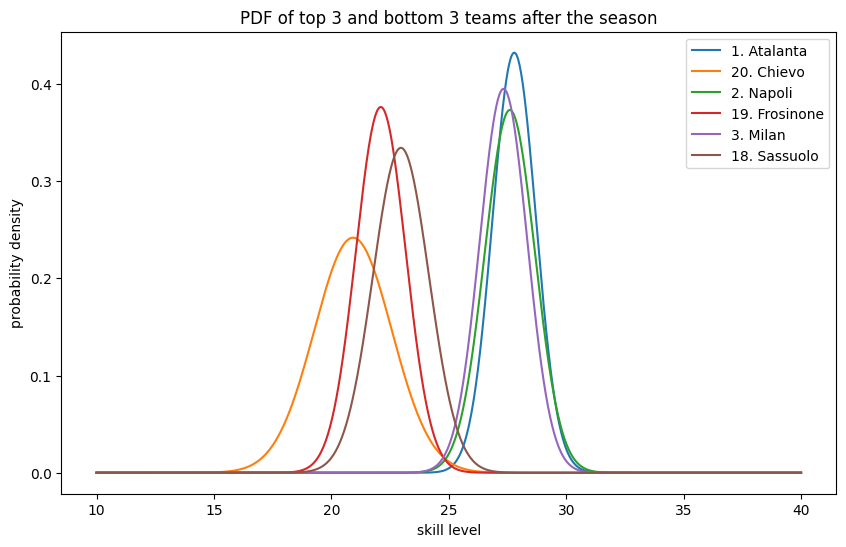

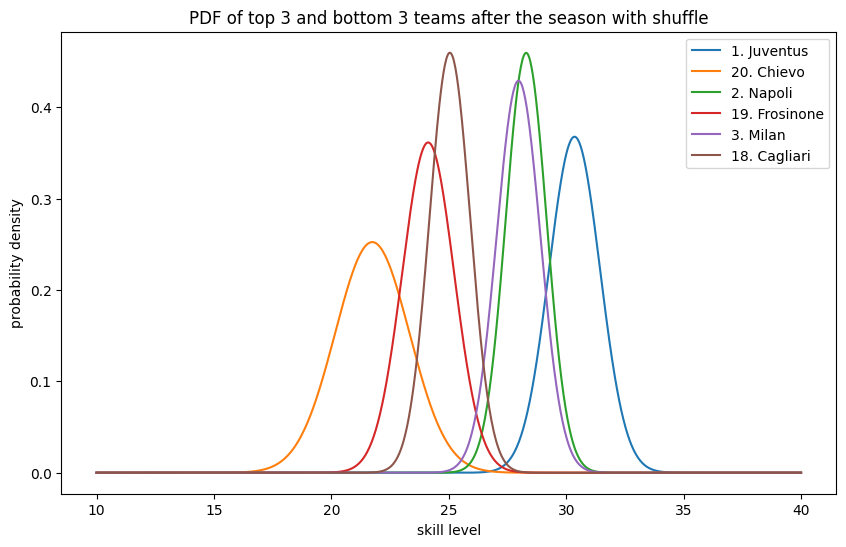

In [24]:
# Plot the pdf of the three top teams and the three bottom teams

plt.figure(figsize=(10, 6))
x = np.linspace(10, 40, 1000)

for i in range(3):
    y_top = stats.norm.pdf(x, teams_df.iloc[i, 0], np.sqrt(teams_df.iloc[i, 1]))
    y_bottom = stats.norm.pdf(x, teams_df.iloc[-i-1, 0], np.sqrt(teams_df.iloc[-i-1, 1]))

    plt.plot(x, y_top, label=f'{i+1}. {teams_df.index[i]}')
    plt.plot(x, y_bottom, label=f'{len(teams_df)-i}. {teams_df.index[-i-1]}')

plt.title('PDF of top 3 and bottom 3 teams after the season')
plt.xlabel('skill level')
plt.ylabel('probability density')
plt.legend()
plt.show()

# Plot the pdf of the three top teams and the three bottom teams after shuffle

plt.figure(figsize=(10, 6))
x = np.linspace(10, 40, 1000)

for i in range(3):
    y_top = stats.norm.pdf(x, teams_df_shuffled.iloc[i, 0], np.sqrt(teams_df_shuffled.iloc[i, 1]))
    y_bottom = stats.norm.pdf(x, teams_df_shuffled.iloc[-i-1, 0], np.sqrt(teams_df_shuffled.iloc[-i-1, 1]))

    plt.plot(x, y_top, label=f'{i+1}. {teams_df_shuffled.index[i]}')
    plt.plot(x, y_bottom, label=f'{len(teams_df_shuffled)-i}. {teams_df_shuffled.index[-i-1]}')

plt.title('PDF of top 3 and bottom 3 teams after the season with shuffle')
plt.xlabel('skill level')
plt.ylabel('probability density')
plt.legend()
plt.show()
